In [18]:
import pandas as pd
import numpy as np
#!pip install xgboost
import xgboost as xgb
from haversine import haversine

In [19]:
taxi_set = pd.read_csv('cleaned_set.csv')
taxi_set.head()

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,y2,distance1,logdistance1,havers_dist,pickup_min,pickup_sec,pickup_day,pickup_date,pickup_mon,speed
0,0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,...,-4637.567460,1.485567,0.910501,1.498523,24,55,0,14,3,11.856445
1,1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,...,-4640.780951,1.694063,0.991050,1.805510,43,35,6,12,6,9.803672
2,2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,...,-4642.385731,4.492538,1.703390,6.385107,35,24,1,19,1,10.822216
3,3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,...,-4642.781602,0.979350,0.682769,1.485500,32,31,2,6,4,12.465738
4,4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,...,-4636.579512,0.776502,0.574646,1.188590,30,55,5,26,3,9.836608


In [20]:
taxi_set.columns

Index(['Unnamed: 0', 'id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'logduration', 'pickup_hour', 'pickup_DayHour', 'x1',
       'y1', 'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist',
       'pickup_min', 'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'speed'],
      dtype='object')

### Converting Trip duration in Hours

In [21]:
taxi_set['trip_dur_in_hr']=taxi_set['trip_duration']/3600

In [22]:
taxi_set['trip_dur_in_hr'].describe()

count    1.458487e+06
mean     2.646940e-01
std      8.809655e-01
min      2.777778e-04
25%      1.102778e-01
50%      1.838889e-01
75%      2.986111e-01
max      2.399778e+01
Name: trip_dur_in_hr, dtype: float64

max value in 23 hour, we gonna remove trip with duration more than 2h

In [23]:
taxi_set=taxi_set[taxi_set['trip_dur_in_hr'] <= 2]

In [24]:
taxi_set['trip_dur_in_hr'].describe()

count    1.456238e+06
mean     2.322628e-01
std      1.817477e-01
min      2.777778e-04
25%      1.102778e-01
50%      1.838889e-01
75%      2.980556e-01
max      1.997500e+00
Name: trip_dur_in_hr, dtype: float64

In [25]:
taxi_set.columns

Index(['Unnamed: 0', 'id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'logduration', 'pickup_hour', 'pickup_DayHour', 'x1',
       'y1', 'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist',
       'pickup_min', 'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'speed', 'trip_dur_in_hr'],
      dtype='object')

In [26]:
def create_datetime(df):

    df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])

    # Hour of the day
    df['pickup_seconds'] = (df['pickup_sec'] + df['pickup_min'] * 60 + df['pickup_hour'] * 3600)
    df['weather']=[1 if (i in [1,2,3]) else(2 if (i in [4,11,12]) else 3) for i in df['pickup_mon']]
    df['quarter']=df['pickup_datetime'].dt.quarter  ## quarter of the year
    df['mid_latitude']=(df['dropoff_latitude']-df['pickup_latitude'])/2
    df['mid_longitude']=(df['dropoff_longitude']-df['pickup_longitude'])/2
    df['night']=[1 if (i==0 or i>=20)  else 0 for i in df['pickup_hour']]
    df['too_late']=[1 if (i<5 and i>0)  else 0 for i in df['pickup_hour']]
    

# Harvesine Distance

def create_distance(df):
    
    #Haversine distance already in the file
    #df['havers_dist'] = df.apply(lambda x: haversine(
        #(x['pickup_latitude'], x['pickup_longitude']),
        #(x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)
    
    #Manhattan distance
    df['Manhattan_dist']=[min(abs(i-j),abs(k-l)) for i,j,k,l in zip(df['x1'],df['y1'],df['x2'],df['y2'])]
    
    #Chebyshev distance
    df['Chebyshev_dist']=[max(abs(i-j),abs(k-l)) for i,j,k,l in zip(df['x1'],df['y1'],df['x2'],df['y2'])]

In [27]:
create_datetime(taxi_set)
create_distance(taxi_set)

‘Lon’ is point A longitude and ‘lat’ is point A latitude
Bearing from point A to B, can be calculated as,

##### β = atan2(X,Y), 
where, X and Y are two quantities and can be calculated as:

##### X = cos lat2 * sin (lon2-lon1)
##### Y = cos lat1 * sin lat2 – sin lat1 * cos lat2 * cos (lon2-lon1)
##### https://www.igismap.com/formula-to-find-bearing-or-heading-angle-between-two-points-latitude-longitude/

In [28]:
def bearing_heading(lat1, lon1, lat2, lon2):
    #R = 6371  # in km
    delta = np.radians(lon2 - lon1)
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    
    X = np.cos(lat2) * np.sin(delta)
    Y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta)
    beta = np.arctan2(X, Y)
    
    return np.degrees(beta)

In [29]:
taxi_set['bearing_direction']=[bearing_heading(i,j,k,l) for i,j,k,l in zip(taxi_set['pickup_latitude'], 
                                                                       taxi_set['pickup_longitude'],
                                                                       taxi_set['dropoff_latitude'], 
                                                                       taxi_set['dropoff_longitude'])]

In [64]:
MSH_list=[]

def create_speed(df):
    #calcul de la vitesse moyenne pour une course
    df['speed'] = df['havers_dist']/df['trip_duration']
    
def create_hour(df):
    #calcul de la tranche horaire du pickup (en heure)
    df['pickup_hour']=df['pickup_datetime'].dt.hour

def create_meanspeedhour_list(df):
    #création d'une liste des meanspeedhour associées à chaque heure et jour
    for j in range (0,7):
        heure0 = round(df['speed'][(df['pickup_hour'] == 0) & (df['pickup_day'] == j)].mean(),6)
        MSH_list.append([heure0])
        for i in range(1,24):
            MSH_list[j].append(round(df['speed'][(df['pickup_hour'] == i) & (df['pickup_day'] == j)].mean(),6))
        
    print(MSH_list)
        
def create_meanspeedhour(df):
    df['average_speed'] = df['pickup_hour']
    for i in range(0,24):
        for j in range (0,7):
            df['average_speed'][(df['pickup_hour'] == i) & (df['pickup_day'] == j)] = MSH_list[j][i]
            
def create_average_duration(df):
    df['average_duration']=df['havers_dist']/df['average_speed']

# create_speed(taxi_set)
# create_hour(taxi_set)

create_meanspeedhour_list(taxi_set)
create_meanspeedhour(taxi_set)
create_average_duration(taxi_set)

[[22.333037, 22.102899, 21.767164, 22.245214, 25.325405, 24.929526, 20.307409, 15.666084, 12.67998, 12.244633, 12.477613, 12.656218, 12.566172, 13.025288, 12.808489, 12.686629, 13.080707, 13.002506, 13.29364, 15.167931, 16.994081, 17.461827, 17.9094, 19.59366], [20.562532, 21.616404, 21.770608, 22.76306, 24.856568, 24.129242, 19.369695, 14.521833, 11.427854, 10.820469, 10.776044, 10.726649, 10.868469, 11.199209, 11.28021, 11.172093, 11.809069, 11.729965, 12.029087, 13.877005, 15.578692, 16.300855, 16.910561, 18.330156], [19.37672, 20.750885, 21.302939, 21.866793, 24.200079, 24.175387, 19.61212, 14.581652, 11.635727, 10.880393, 10.850843, 10.574472, 10.500417, 10.855851, 10.825831, 10.777402, 11.457749, 11.293764, 11.617042, 13.075672, 15.054876, 15.815213, 16.166591, 17.455462], [18.832671, 20.479438, 20.9045, 22.270679, 23.993528, 24.207339, 19.665303, 14.573742, 11.477658, 10.98505, 10.967974, 10.79351, 10.737044, 11.178609, 10.951684, 10.808606, 11.436034, 11.424415, 11.6072, 12.862

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [66]:
taxi_set.columns

Index(['Unnamed: 0', 'id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'logduration', 'pickup_hour', 'pickup_DayHour', 'x1',
       'y1', 'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist',
       'pickup_min', 'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'speed', 'trip_dur_in_hr', 'pickup_seconds', 'weather', 'quarter',
       'mid_latitude', 'mid_longitude', 'night', 'too_late', 'Manhattan_dist',
       'Chebyshev_dist', 'bearing_direction', 'average_speed',
       'average_duration'],
      dtype='object')

In [68]:
## drop columns to avoid data type problems in xgboost
train=taxi_set.drop(['id',
                     # 'vendor_id',
                     'Unnamed: 0',
                     'pickup_datetime',
                     'dropoff_datetime',
                     'store_and_fwd_flag',
                     'logduration',
                     'trip_dur_in_hr',
                     'pickup_DayHour',
                     'speed',
                     'too_late',
                     'night',
                     'quarter',
                     'weather',
                    ],1)

In [69]:
train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'pickup_hour',
       'x1', 'y1', 'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist',
       'pickup_min', 'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'pickup_seconds', 'mid_latitude', 'mid_longitude', 'Manhattan_dist',
       'Chebyshev_dist', 'bearing_direction', 'average_speed',
       'average_duration'],
      dtype='object')

In [70]:
y=np.log(train['trip_duration'].values + 1)
x=train.drop(['trip_duration'],1)

### xgboost

In [71]:
from sklearn.model_selection import train_test_split
Xtrain, Xvalid, ytrain, yvalid = train_test_split(x, y, test_size=0.2, random_state=1996)

In [72]:
dtrain = xgb.DMatrix(Xtrain, label=ytrain)

In [78]:
dvalid = xgb.DMatrix(Xvalid, label=yvalid)
#dtest = xgb.DMatrix(test[feature_names].values)
evallist = [(dtrain, 'train'), (dvalid, 'valid')]

num_round = 100000
#From mayank's kernel
xgb_pars = {
    'min_child_weight': 10,
    'eta': 0.03,
    'colsample_bytree': 0.3,
    'max_depth': 10,
    'subsample': 0.8,
    'lambda': 1,
    'nthread': -1,
    'booster' : 'gbtree',
    'silent': 1,
    'eval_metric': 'rmse',
    'objective': 'reg:linear'
}

In [79]:
from sklearn.model_selection import GridSearchCV
import os
from multiprocessing import set_start_method
# set_start_method("forkserver")

os.environ["OMP_NUM_THREADS"] = "8"

In [81]:
scores = {}
# for eta in [x / 50 for x in range(1, 50)]:
#    xgb_pars['eta'] = eta
#    model = xgb.train(
#         xgb_pars,
#        dtrain,
#        num_round,
#        evallist,
#        early_stopping_rounds=40,
#        maximize=False,
#        verbose_eval=20
#    )
#    print(' ===> Modeling RMSLE %.5f' % model.best_score)
#    scores[eta] = model.best_score
#print(scores)
model = xgb.train(
    xgb_pars,
    dtrain,
    num_round,
    evallist,
    early_stopping_rounds=40,
    maximize=False,
    verbose_eval=20
)

[0]	train-rmse:5.89078	valid-rmse:5.88947
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 40 rounds.
[20]	train-rmse:3.94597	valid-rmse:3.94503
[40]	train-rmse:2.65115	valid-rmse:2.65054
[60]	train-rmse:1.79247	valid-rmse:1.79232
[80]	train-rmse:1.22836	valid-rmse:1.22885
[100]	train-rmse:0.863586	valid-rmse:0.864996
[120]	train-rmse:0.634261	valid-rmse:0.63698
[140]	train-rmse:0.497035	valid-rmse:0.501438
[160]	train-rmse:0.419621	valid-rmse:0.425802
[180]	train-rmse:0.378093	valid-rmse:0.385979
[200]	train-rmse:0.356354	valid-rmse:0.365796
[220]	train-rmse:0.344357	valid-rmse:0.355197
[240]	train-rmse:0.337396	valid-rmse:0.349604
[260]	train-rmse:0.332929	valid-rmse:0.346552
[280]	train-rmse:0.329217	valid-rmse:0.344128
[300]	train-rmse:0.326407	valid-rmse:0.342596
[320]	train-rmse:0.324252	valid-rmse:0.341484
[340]	train-rmse:0.321929	valid-rmse:0.340308
[360]	train-rmse:0.319804	valid-rmse:0.33928

KeyboardInterrupt: 

In [82]:
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.32036


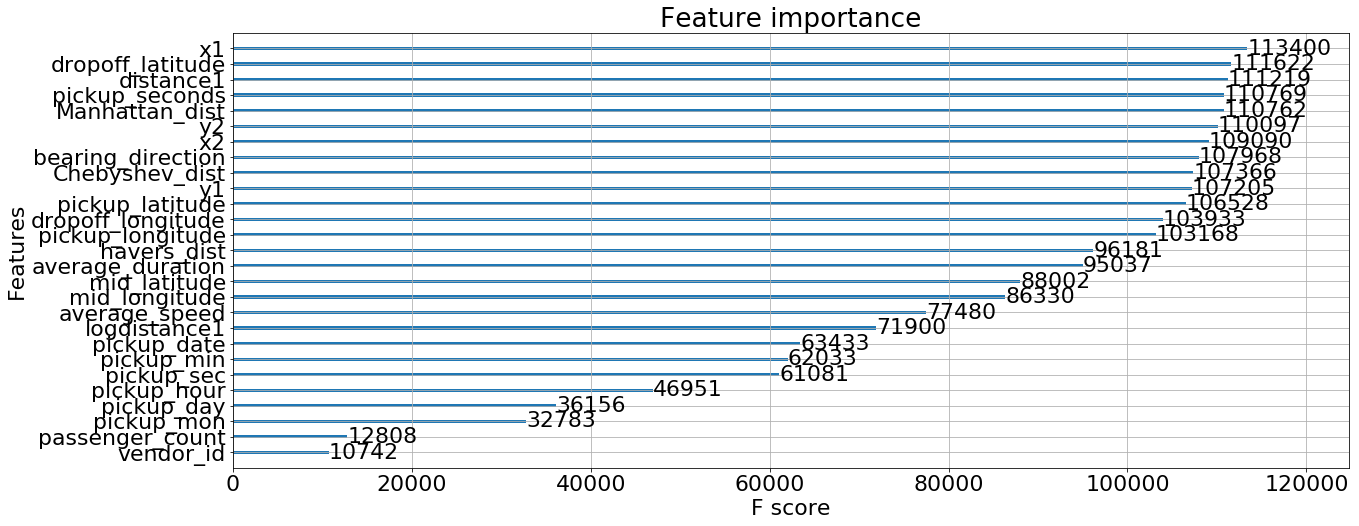

In [84]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = (20.0, 8.0)
matplotlib.rcParams['font.size'] = 22

xgb.plot_importance(model, ax=None, height=0.2, xlim=None,
                    ylim=None, title='Feature importance',
                    xlabel='F score', ylabel='Features',
                    importance_type='weight', max_num_features=None,
                    grid=True)
plt.show()


In [59]:
import pickle
pickle.dump(model,open('xgb_pred.sav','wb'))

# TEST

In [110]:
test_dataset = pd.read_csv('data/test.csv')

In [111]:
test_dataset.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

In [112]:
#Latitude and Longitude to cartesian cordindates converesion
# Assuming Earth as sphere not ellipsoid 
def cartesian_x(lat,lon):
    lat=np.radians(lat)
    lon=np.radians(lon)
    R=6371.0
    x = R * np.cos(lat) * np.cos(lon)
    return x
def cartesian_y(lat,lon):
    lat=np.radians(lat)
    lon=np.radians(lon)
    R=6371.0
    y = R * np.cos(lat) * np.sin(lon)
    return y
# extracting cartesian x,y cordinates form latitude and longitude
test_dataset['x1']=[cartesian_x(i,j) for i,j in zip(test_dataset['pickup_latitude'],test_dataset['pickup_longitude'])]
test_dataset['y1']=[cartesian_y(i,j) for i,j in zip(test_dataset['pickup_latitude'],test_dataset['pickup_longitude'])]
test_dataset['x2']=[cartesian_x(i,j) for i,j in zip(test_dataset['dropoff_latitude'],test_dataset['dropoff_longitude'])]
test_dataset['y2']=[cartesian_y(i,j) for i,j in zip(test_dataset['dropoff_latitude'],test_dataset['dropoff_longitude'])]

In [113]:
def euclidean_distance(a1,b1,a2,b2):
    dist=np.sqrt((a2-a1)**2+(b2-b1)**2)
    return dist
    
test_dataset['distance1']=[euclidean_distance(i,j,k,l) for i,j,k,l in zip(test_dataset['x1'], 
                                                                          test_dataset['y1'],
                                                                          test_dataset['x2'], 
                                                                          test_dataset['y2'])]

test_dataset['logdistance1']=np.log(test_dataset['distance1']+1)

In [114]:
def create_distance1(df):
    
    #Haversine distance already in the file
    df['havers_dist'] = df.apply(lambda x: haversine(
        (x['pickup_latitude'], x['pickup_longitude']),
        (x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)
    
    #Manhattan distance
    df['Manhattan_dist']=[min(abs(i-j),abs(k-l)) for i,j,k,l in zip(df['x1'],df['y1'],df['x2'],df['y2'])]
    
    #Chebyshev distance
    df['Chebyshev_dist']=[max(abs(i-j),abs(k-l)) for i,j,k,l in zip(df['x1'],df['y1'],df['x2'],df['y2'])]

def create_datetime_weekmont(df):
    
    df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_min'] = df['pickup_datetime'].dt.minute
    df['pickup_sec'] = df['pickup_datetime'].dt.second
    df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
    df['pickup_date'] = df['pickup_datetime'].dt.day
    df['pickup_mon'] = df['pickup_datetime'].dt.month

In [115]:
create_distance1(test_dataset)
create_datetime_weekmont(test_dataset)
create_datetime(test_dataset)

test_dataset['bearing_direction']=[bearing_heading(i,j,k,l) for i,j,k,l in zip(test_dataset['pickup_latitude'], 
                                                                       test_dataset['pickup_longitude'],
                                                                       test_dataset['dropoff_latitude'], 
                                                                       test_dataset['dropoff_longitude'])]



In [117]:
#create_meanspeedhour_list(test)
create_meanspeedhour(test_dataset)
create_average_duration(test_dataset)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [118]:
test_dataset.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'x1', 'y1', 'x2', 'y2',
       'distance1', 'logdistance1', 'havers_dist', 'Manhattan_dist',
       'Chebyshev_dist', 'pickup_hour', 'pickup_min', 'pickup_sec',
       'pickup_day', 'pickup_date', 'pickup_mon', 'pickup_seconds', 'weather',
       'quarter', 'mid_latitude', 'mid_longitude', 'night', 'too_late',
       'bearing_direction', 'average_speed', 'average_duration'],
      dtype='object')

In [126]:
## drop columns to avoid data type problems in xgboost
test=test_dataset.drop(['id',
                     # 'vendor_id',
                     # 'Unnamed: 0',
                     'pickup_datetime',
                     # 'dropoff_datetime',
                     'store_and_fwd_flag',
                     # 'logduration',
                     # 'trip_dur_in_hr',
                     # 'pickup_DayHour',
                     # 'speed',
                     'too_late',
                     'night',
                     'quarter',
                     'weather',
                    ],1)

In [127]:
# test.insert(0, 'Unnamed: 0', range(0, len(test)))

In [133]:
print(test.columns)
len(test.columns)

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'x1', 'y1', 'x2', 'y2',
       'distance1', 'logdistance1', 'havers_dist', 'Manhattan_dist',
       'Chebyshev_dist', 'pickup_hour', 'pickup_min', 'pickup_sec',
       'pickup_day', 'pickup_date', 'pickup_mon', 'pickup_seconds',
       'mid_latitude', 'mid_longitude', 'bearing_direction', 'average_speed',
       'average_duration'],
      dtype='object')


27

In [134]:
print(x.columns)
len(x.columns)

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'x1', 'y1',
       'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist', 'pickup_min',
       'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
       'pickup_seconds', 'mid_latitude', 'mid_longitude', 'Manhattan_dist',
       'Chebyshev_dist', 'bearing_direction', 'average_speed',
       'average_duration'],
      dtype='object')


27

In [136]:
# model=pickle.load(open('xgb_pred.sav','rb'))
model = model
# dtest = xgb.DMatrix(test[[
#        # 'Unnamed: 0',
#        'passenger_count', 'pickup_longitude', 'pickup_latitude',
#        'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'x1', 'y1',
#        'x2', 'y2', 'distance1', 'logdistance1', 'havers_dist', 'pickup_min',
#        'pickup_sec', 'pickup_day', 'pickup_date', 'pickup_mon',
#        'pickup_seconds',
#        'vendor_id',
#         # 'weather', 'quarter', 'too_late', 'night',
#        'mid_latitude', 'mid_longitude',
#        'Manhattan_dist', 'Chebyshev_dist',
#        'bearing_direction',
#        'average_speed', 'average_duration'  
# ]])
dtest = xgb.DMatrix(test[x.columns])
ytest = model.predict(dtest)


In [137]:
np.exp(np.round(ytest[1:10]))-1

array([ 402.4288,  402.4288, 1095.6332,  402.4288, 1095.6332, 1095.6332,
       1095.6332, 2979.958 ,  402.4288], dtype=float32)

In [138]:
test['trip_duration'] = np.round(np.exp(ytest)) - 1

In [139]:
test_dataset['trip_duration']=np.round(np.exp(ytest)) - 1

In [140]:
test_dataset[['id', 'trip_duration']].to_csv('submission12.csv', index=False)